# Head movements during gaze aversions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import colorcet as cc
import scipy.stats as stats
import csv
import math
from numpy.linalg import inv
import transforms3d.euler as eul

In [2]:
set_WD = os.getcwd() # get current work directory

# Import files for subjective analysis
rater_1 = pd.read_excel(set_WD+ r"\data\processed_data\head_movements\head_movement_first_rater.xlsx")
rater_2 = pd.read_excel(set_WD+ r"\data\processed_data\head_movements\head_movement_second_rater.xlsx")

# Import file for objective analysis
openface = pd.read_csv(set_WD+ r"\data\processed_data\head_movements\openface_check.csv") # file is named openface because it contains the columns OpenFace_VD and OpenFace_baseline contain 1 if openface did an accurate landmarks detection for gaze aversion and baseline screenshots respectively
openface_results_dir = set_WD+ "/data/processed_data/head_movements/openface results all screenshots/" # Directory with Openface csv output files for all screenshots (gaze aversions (called VD) and baselines for every gaze aversion)

# Import file containing quality of memories (will be used to remove question where the memory does not meet autobiographical criteria)
quality_data = pd.read_csv(set_WD+ r"\data\processed_data\T1_quality.csv")

# set a path to save figures and data
wd_output_files=set_WD+ r"\data\processed_data\head_movements\\"# path to a directory where the files will be saved
wd_output_fig=set_WD+ r"\data\figures\\" # path to a directory where the figures will be saved

# Subjective analysis of head movements

### Code to reproduce figure from the paper

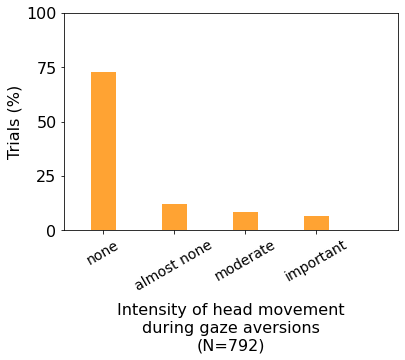

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)


head_mov = list(rater_1['head movement'].value_counts())
for i in range(len(head_mov)):
    head_mov[i] = head_mov[i]/len(rater_1)*100
    
N = len(head_mov)

ind = np.arange(N)
width = 0.35     

rects2 = ax.bar(ind+width/1.70, head_mov, width,
                    color='darkorange', alpha = 0.8)

ax.set_xticks([0.20,1.2,2.2,3.2])
ax.set_xticklabels(["none", "almost none", "moderate", "important"],fontsize=14, rotation = 30)
plt.yticks([0,25, 50, 75, 100], fontsize=16)

ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,100)
ax.set_ylabel('Trials (%)', fontsize = 16)
ax.set_xlabel('Intensity of head movement\nduring gaze aversions\n' +"(N="+str(len(rater_1['head movement']))+')', fontsize = 16, labelpad=10)

plt.savefig(wd_output_fig+"subjective_evaluation_head.png",bbox_inches = "tight")
plt.show()

### Code to calculate inter-rater concordance

In [4]:
# Calculate Kendall's Tau and p-value

tau, p_value = stats.kendalltau(rater_2['head movement rater2'], rater_2['head movement rater1'])
print('tau =', tau)
print('p-value =', p_value)

tau = 0.3750772730448975
p-value = 0.00021203419831076947


# Quantitative evaluation of head movement

NOTE
We used OpenFace 2.0 to measure head rotations and eye angles.
https://github-wiki-see.page/m/TadasBaltrusaitis/OpenFace/wiki/Output-Format

DISCLAIMER
For every screenshot, openface output prodived a picture with landmarks detection, a txt file with parameters and a csv file with head and eye orientations.
In the openface_results_dir (publicly available), only the .csv files are shared in respect to the protection of personal data because the other files are not anonymous and would allow the identification of participants.

Because participants wore masks, all the detection from OpenFace have been manually verified and only the trials with accurate landmarks detection are kept for analyses.
--> results in openface_check.csv

In [5]:
# list of all files in Openface output directory
os.chdir(openface_results_dir)
lst_files = os.listdir()
lst_files.sort()
lst_files
# keep only .csv files 
lst_csv = []
for csv_file in lst_files:
    if ".csv" in csv_file:
        lst_csv.append(csv_file)
    
sujets =['P01','P02','P03','P04','P05','P06', \
      'P07','P09','P10','P11','P12','P13', \
      'P14','P15','P16','P17','P18', \
      'P19', 'P20', 'P21', 'P22', 'P23', 'P24', \
       'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33'] # list of all the participants with their anonymized code

In [6]:
# Create a dataframe containing the openface output data for all the trials where the detection was accurate
# = df_face_orientation

code_sujet = []
question_name = []

pitch_Rx_baseline = []
yaw_Ry_baseline = []
roll_Rz_baseline = []

gaze_angle_x_baseline = []
gaze_angle_y_baseline = []

pitch_Rx_VD = []
yaw_Ry_VD = []
roll_Rz_VD = []

gaze_angle_x_VD = [] # gaze angle in radiants
gaze_angle_y_VD = []
# x = left-right (left is positive)
# y = up-down (down is positive)

corrected_orientation_video = [] # orientation of the gaze aversion based on the eye-tracker and manual correction of videos

# Add the 3D vector of one eye for gaze direction to the table
eye_vector_X_VD =[] 
eye_vector_Y_VD =[]
eye_vector_Z_VD =[] 
eye_vector_X_baseline =[] 
eye_vector_Y_baseline =[]
eye_vector_Z_baseline =[] 

nb = 0
n = 0
r = 0

sujet_prec = 0
question_prec = 0
for i in range(len(openface['sujet'])):
    if openface['OpenFace_VD'][i] == 1 and openface['OpenFace_baseline'][i] == 1 : # keep only trials where the accuracy of the landmarks detection was good both during gaze aversion and baseline
        sujet = openface['sujet'][i]
        question = openface['audio'][i]
        question_baseline = question[5:-4] + '_baseline'
        question_VD = question[5:-4] + '_VD'
        trial_baseline = [csv for csv in lst_csv if sujet in csv and question_baseline in csv]
        trial_VD = [csv for csv in lst_csv if sujet in csv and question_VD in csv]

        nb = nb + 1
        
        if question != question_prec or sujet != sujet_prec:   

            for VD in range(len(trial_VD)):
                df_VD = pd.read_csv(openface_results_dir + trial_VD[VD])

                df_baseline = pd.read_csv(openface_results_dir + trial_baseline[0])

                if len(df_baseline) ==1 and len(df_VD) ==1:
                    n = n + 1
                    code_sujet.append(sujet)
                    question_name.append(question[5:-4])
                    corrected_orientation_video.append(openface['corrected_orientation_video'][i])

                    pitch_Rx_baseline.append(df_baseline[' pose_Rx'][0]) # baseline = screenshot of participant during the end of the question
                    yaw_Ry_baseline.append(df_baseline[' pose_Ry'][0])
                    roll_Rz_baseline.append(df_baseline[' pose_Rz'][0])

                    gaze_angle_x_baseline.append(df_baseline[' gaze_angle_x'][0])
                    gaze_angle_y_baseline.append(df_baseline[' gaze_angle_y'][0])
                    
                    eye_vector_X_baseline.append(df_baseline[' gaze_1_x'][0])
                    eye_vector_Y_baseline.append(df_baseline[' gaze_1_y'][0])
                    eye_vector_Z_baseline.append(df_baseline[' gaze_1_z'][0])

                    pitch_Rx_VD.append(df_VD[' pose_Rx'][0]) # VD = screenshot of the participant when the gaze aversion was present during the access memory phase
                    yaw_Ry_VD.append(df_VD[' pose_Ry'][0])
                    roll_Rz_VD.append(df_VD[' pose_Rz'][0])

                    gaze_angle_x_VD.append(df_VD[' gaze_angle_x'][0])
                    gaze_angle_y_VD.append(df_VD[' gaze_angle_y'][0])
                    
                    eye_vector_X_VD.append(df_VD[' gaze_1_x'][0])
                    eye_vector_Y_VD.append(df_VD[' gaze_1_y'][0])
                    eye_vector_Z_VD.append(df_VD[' gaze_1_z'][0])
                    
                    

        sujet_prec = sujet
        question_prec = question
        
df_face_orientation = pd.DataFrame({'sujet':code_sujet, 'question':question_name, 'corrected_orientation_video': corrected_orientation_video, \
                                     'pitch_Rx_baseline': pitch_Rx_baseline, 'yaw_Ry_baseline': yaw_Ry_baseline, \
                                     'roll_Rz_baseline': roll_Rz_baseline, 'gaze_angle_x_baseline':gaze_angle_x_baseline, 'gaze_angle_y_baseline':gaze_angle_y_baseline, \
                                     'pitch_Rx_VD': pitch_Rx_VD, 'yaw_Ry_VD': yaw_Ry_VD, 'roll_Rz_VD': roll_Rz_VD, \
                                     'gaze_angle_x_VD':gaze_angle_x_VD, 'gaze_angle_y_VD':gaze_angle_y_VD, \
                                     'eye_vector_X_baseline':eye_vector_X_baseline, 'eye_vector_Y_baseline':eye_vector_Y_baseline, 'eye_vector_Z_baseline':eye_vector_Z_baseline, \
                                     'eye_vector_X_VD':eye_vector_X_VD, 'eye_vector_Y_VD':eye_vector_Y_VD, 'eye_vector_Z_VD':eye_vector_Z_VD})

# complete dataframe with other variables of interest for further analyses
df_face_orientation['clarte'] = ''
df_face_orientation['effort'] = ''
df_face_orientation['quality'] = '' # score à l'Etape 2
df_face_orientation['autobio'] = '' # score Etape 1 (fits the criteria of autobiographical memories or not)

for i in range(len(df_face_orientation['sujet'])):
    suj = df_face_orientation['sujet'][i]
    quest = 'auto_' + df_face_orientation['question'][i] + '.wav'
    
    data = quality_data[quality_data['Sujet'] == suj]
    data = data[data['audio'] == quest]
    index = data[data['audio'] == quest].index.tolist()
    if index:   
        #print(index)
        df_face_orientation['clarte'][i] = data['clarte'][index[0]]
        df_face_orientation['effort'][i] = data['effort '][index[0]]
        df_face_orientation['quality'][i] = data['Etape_2'][index[0]]
        df_face_orientation['autobio'][i] = data['Etape_1'][index[0]]

# delete all memories which are not autobiographical
df_face_orientation = df_face_orientation[df_face_orientation['autobio'] == 'A']
df_face_orientation.reset_index(level=None, drop=False, inplace=True, col_level=0, col_fill='')

C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:116: SettingWithCopyWarning: 
A 

In [7]:
# For each gaze aversion calculate the difference between baseline and gaze aversion to calculate the amplitude of the movement between both
# The change between baseline and gaze aversion is a substraction of gaze aversion position - baseline position
# these data are added to the dataframe in columns containing "change"

# change in radiants
df_face_orientation['change_pitch_x_radiant'] = ''
df_face_orientation['change_yaw_y_radiant'] = ''
df_face_orientation['change_roll_z_radiant'] = ''

df_face_orientation['change_gaze_angle_x_radiant'] = ''
df_face_orientation['change_gaze_angle_y_radiant'] = ''

for i in range(len(df_face_orientation['sujet'])):
    df_face_orientation['change_pitch_x_radiant'][i] = df_face_orientation['pitch_Rx_VD'][i] - df_face_orientation['pitch_Rx_baseline'][i]
    df_face_orientation['change_yaw_y_radiant'][i] = df_face_orientation['yaw_Ry_VD'][i] - df_face_orientation['yaw_Ry_baseline'][i]
    df_face_orientation['change_roll_z_radiant'][i] = df_face_orientation['roll_Rz_VD'][i] - df_face_orientation['roll_Rz_baseline'][i]
    
    df_face_orientation['change_gaze_angle_x_radiant'][i] = df_face_orientation['gaze_angle_x_VD'][i] - df_face_orientation['gaze_angle_x_baseline'][i]
    df_face_orientation['change_gaze_angle_y_radiant'][i] = df_face_orientation['gaze_angle_y_VD'][i] - df_face_orientation['gaze_angle_y_baseline'][i]

# change in degrees
nb_of_degrees_in_1_radian = (360/math.pi)/2

df_face_orientation['change_pitch_x_degree'] = ''
df_face_orientation['change_yaw_y_degree'] = ''
df_face_orientation['change_roll_z_degree'] = ''

df_face_orientation['change_gaze_angle_x_degree'] = ''
df_face_orientation['change_gaze_angle_y_degree'] = ''

for i in range(len(df_face_orientation['sujet'])):
    df_face_orientation['change_pitch_x_degree'][i] = df_face_orientation['change_pitch_x_radiant'][i]*nb_of_degrees_in_1_radian
    df_face_orientation['change_yaw_y_degree'][i] = df_face_orientation['change_yaw_y_radiant'][i]*nb_of_degrees_in_1_radian
    df_face_orientation['change_roll_z_degree'][i] =df_face_orientation['change_roll_z_radiant'][i]*nb_of_degrees_in_1_radian
    
    df_face_orientation['change_gaze_angle_x_degree'][i] = df_face_orientation['change_gaze_angle_x_radiant'][i]*nb_of_degrees_in_1_radian
    df_face_orientation['change_gaze_angle_y_degree'][i] = df_face_orientation['change_gaze_angle_y_radiant'][i]*nb_of_degrees_in_1_radian


C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\anais\anaconda3\lib

### Calculate eye rotation in the reference of the head 
By default, eye angles are given in respect to the camera with OpenFace.
https://github.com/TadasBaltrusaitis/OpenFace/issues/769

In [8]:
# R(h_e) = R(h)*R(e)
# R(e) = R(h).transpose()*(Rh_e) where R is a matrix, e is eye and h is head --> h_e is the eye in the head reference

df_face_orientation['corrected_eye_pitch_in_head_reference'] = ''
df_face_orientation['corrected_eye_yaw_in_head_reference'] = ''
import transforms3d.euler as eul
roll = []
for i in range(len(df_face_orientation)):
    eye_vector_XYZ_baseline = [df_face_orientation['gaze_angle_x_baseline'][i], df_face_orientation['gaze_angle_y_baseline'][i],0.041] # given as a position vector in camera reference ( gaze_0_x	 gaze_0_y	 gaze_0_z)
    eye_vector_XYZ_VD = [df_face_orientation['gaze_angle_x_VD'][i], df_face_orientation['gaze_angle_y_VD'][i], -0.020] # given as a position vector in camera reference
    euler_angles_head_yaw_pitch_roll_baseline = [ -df_face_orientation['yaw_Ry_baseline'][i], -df_face_orientation['pitch_Rx_baseline'][i], df_face_orientation['roll_Rz_baseline'][i]] # given as euler angles yaw pitch roll (yaw around x, pitch around y, and roll around z),  pose_Rx	 pose_Ry	 pose_Rz
    euler_angles_head_yaw_pitch_roll_VD = [ -df_face_orientation['yaw_Ry_VD'][i], -df_face_orientation['pitch_Rx_VD'][i], df_face_orientation['roll_Rz_VD'][i]]

    HEAD_Rotation_matrix_baseline = eul.euler2mat(*euler_angles_head_yaw_pitch_roll_baseline, axes='szyx')
    HEAD_Rotation_matrix_VD = eul.euler2mat(*euler_angles_head_yaw_pitch_roll_VD , axes='szyx')

    EYE_Rotation_matrix_baseline = eul.euler2mat(*eye_vector_XYZ_baseline, axes='szyx')
    EYE_Rotation_matrix_VD = eul.euler2mat(*eye_vector_XYZ_VD,  axes='szyx')

    Re_baseline = HEAD_Rotation_matrix_baseline.transpose()@EYE_Rotation_matrix_baseline
    Re_VD = HEAD_Rotation_matrix_VD.transpose()@EYE_Rotation_matrix_VD
    
    euler_ang_baseline = eul.mat2euler(Re_baseline, axes='szyx')
    euler_ang_VD = eul.mat2euler(Re_VD, axes='szyx')

    df_face_orientation['corrected_eye_pitch_in_head_reference'][i] = (euler_ang_VD[0] - euler_ang_baseline[0])*nb_of_degrees_in_1_radian
    df_face_orientation['corrected_eye_yaw_in_head_reference'][i] = (euler_ang_VD[1] - euler_ang_baseline[1])*nb_of_degrees_in_1_radian
    roll.append((euler_ang_VD[2] - euler_ang_baseline[2])*nb_of_degrees_in_1_radian)

df_face_orientation= df_face_orientation.drop(df_face_orientation.index[47]) # remove extrema value
df_face_orientation.to_csv(wd_output_files + "head_movements_ready_for_analyses.csv") # save this dataframe containing all the values of eye and head movements necessary for analyses

C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anais\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Code to reproduce histograms from the paper with distribution of eye and head movement
### yaw (horizontal movements) and pitch (vertical movements)

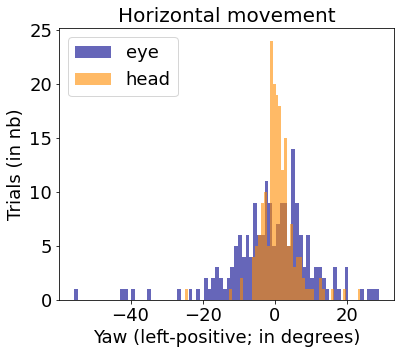

In [9]:
plt.figure(figsize=(6, 5))
plt.hist(df_face_orientation['corrected_eye_yaw_in_head_reference'], color = 'darkblue', bins = 80, alpha = 0.6, label = 'eye')
plt.hist(-df_face_orientation['change_yaw_y_degree'], color = 'darkorange', bins = 60, alpha = 0.6, label = 'head')
plt.legend(fontsize = 18)
plt.title('Horizontal movement', fontsize = 20)
plt.xlabel('Yaw (left-positive; in degrees)', fontsize = 18)
plt.ylabel('Trials (in nb)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks([0,5, 10, 15, 20, 25], fontsize = 18)
plt.savefig(wd_output_fig + 'head_movement_yaw.jpg',bbox_inches = "tight")
plt.show()

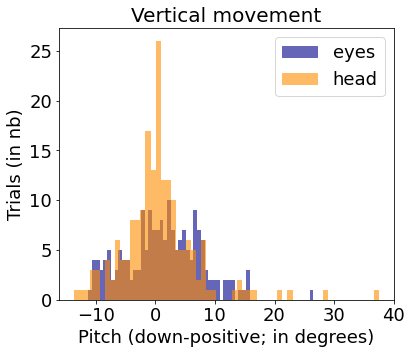

In [10]:
plt.figure(figsize=(6, 5))
plt.hist(df_face_orientation['corrected_eye_pitch_in_head_reference'], color = 'darkblue', bins = 60, alpha = 0.6, label = 'eyes')
plt.hist(-df_face_orientation['change_pitch_x_degree'], color = 'darkorange', bins = 60, alpha = 0.6, label = 'head')
plt.legend(fontsize = 18)
plt.title('Vertical movement', fontsize = 20)
plt.xlabel('Pitch (down-positive; in degrees)', fontsize = 18)
plt.ylabel('Trials (in nb)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks([0,5, 10, 15, 20, 25], fontsize = 18)

plt.savefig(wd_output_fig + 'head_movement_pitch.jpg',bbox_inches = "tight")
plt.show()